# Basic example to perform UVP measurements with the peacock
The original API before modifications were downloaded from the github repository


## Version history:

V1-modified by J.Noir:04/04/2021: 
*  renamed dict keys, more explicit keys 
*  The new api includes a command apf_instance.read_sound_speed(): read sound speed from the board
*  Use the key 'overlap' to specify the distance between gates: 0.5 -> 50% overlap, 1-> no overlap, 2-> gate_distance=2*gate_size 
* the default_settings.json file has been modified to include the sound speed in the parameters and the new key overlap
* added a field 'soundspeed' in the settings dict, the function '<>.set(settings)' of the class hass beenmodified in apf04_config_hw.py (see from_dict first line), it reads the soundspeed from the settings directly.

V2-modified by J.Noir:25.11.2021:
* You must specify the path to a default_config to avoid problems with division by zero in case some parameters of the board have been reset. Not sure why, maybe if it is not connected for too long ?
* I would recommand you keep you default_settings.json in the same directory as the note book.


This notebook is a modified code of the test_apf_driver.py provided by Stephane Fischer from Ubertone on 08/01/2021. It illustrates the most important functions of the API and how to perform basic measurements.

## requirement

pyserial==3.5

## Hardware and OS tested:

* "Macbook Pro Retina 13inch early 2015" Operating system: BigSur 11.0.1 
* Macbook Pro 16" 2017 with BigSur 11.1 
* Macbook Pro 16" 2017 with Monterey 12.0.1




## setting up the librairies:

If you want to use your general python library folder you must copy all the files from the API folder into you python library folder dedicated to the peacock. 

In this notebook I am only using the local API folder.


## Reading / modifying / load copnfiguration on the Peacock:

Before starting the acquisition you must select the config you want to use 0,1, or 2 and run a check, then read the config from the board and store it in a variable _config_.

The variable you will manipulate to change the parameters is a dictionnary, I call that settings. What is written on the board is already in a format that would make no sense to us, I call this a config. 

Open the json file to see its structure it is self-explanatory, it contains all the variables we need to generate a configuration. 

Be aware that the parameters your entered in your intial settings may not be self-consistent, for instance you may have chosen a prf, n_vol  and r_em,r_dvol that are not compatible, see how and when this value will be corrected as you upload the config and check it. 

here is the list of adjustable parameters:
*  'sounspeed': soundspeed in the medium
*  'tr_out' : Channel used 'tr1' or 'tr2'
*  'f0':Emisson frequency
*  'prf':  PRF
*  'nb_emission_per_profile': number of bursts per profile
*  'nb_profile_average': number of profiles averaged
*  'nb_gate':  Number of sampling volume (gates)
*  'overlap': Overlap between gates: 0.5=50\%, 1=no overlap, 2=distance between gates = 2xgate size
*  'distance_first_gate':  Position of the first sampling volume in m
*  'v_min': min velocity (adjust to offset the velocity range, vmax is recalculated accordingly)
*  'gain_function': {'a0': 19.97945, 'a1': 0.0, 'auto': True},: defines the gain function (see modbus_manual)
*  'method': 'ppc_cont', (Not sure abour this)
*  'static_echo_filter': True, : to remove statis echo
*  'phase_coding': True, (Not sure about that one)




The following parameters are calculated from your input values
*  'dynamicRange' : Velocity dynamic range = Soundspeed*PRF/2/f0
*  'gate_size':  Volume size =settings['soundspeed']/(2.*settings['f_emission'])*settings['nb_cycles_per_emission']
*  'gate_distance': distance between sampling volume = settings['gate_size']*settings['overlap']
*  'v_max': velocity_offset + dynamicRange/2

You can redefine which parameters are input and which are recalculated based your specific application, just remember they are not all independent. 



# IMPORT using local API Folder

In [1]:
from API.apf04_driver import Apf04Driver
from API.low_level_functions_JN import *
from matplotlib.pyplot import *


# #you may want to change that depending on your jupyter set-up
# style.use('ggplot')
# %matplotlib qt


We now create a instance of the driver which will allow us to comunicate with the board.

As I understand 18e6 is a frequency that is specific to our version of the peacock and should not be changed, the BAUD is by default 230400, not sure when we may need to change that. As it is it works for me.

# Create instance driver

In [4]:
# Create an instance of the Peacock's driver (with 230400 BAUD rate)
myPeacock = Apf04Driver(230400, 18e6)
# Read the firmware version
myPeacock.read_version()

(85, 47)

# LOAD the settings from the Json file

This is recommanded the each time you connect a board. 

In [ ]:
fileName = './myConfig.json'
mySettings=load_settings_fromFile(fileName)

###########################################


Loaded settings


soundspeed :  1509
f_emission :  2571428.5714285714
tr_out :  tr1
prf :  1000.1666944490748
nb_cycles_per_emission :  128
overlap :  0.5
nb_emission_per_profile :  128
position_first_gate :  0.019952333333333336
gate_distance :  0.018778666666666666
nb_gates :  38
gate_size :  0.03755733333333333
method :  ppc_cont
phase_coding :  True
static_echo_filter :  True
gain_function :  {'auto': False, 'a0': 39.96329, 'a1': 0.0}
nb_profile_average :  1
v_min :  -0.06428613461466386
dynamicRange :  0.29346557759626607
v_max :  0.2291794429816022
###########################################


# MODIFY the settings

In [14]:
#Change values of the settings-MAKE SURE YOU HAVE THE CORRECT "soundspeed" AND
#CHANNEL "tr_out".
#I added usefull information in the settings such as dynamicRange, vmin, vmax, 
#these need to be recalculated so after you modify the settings you need to run update_settings

        
mySettings['soundspeed']=2300
mySettings['f_emission']=2e6
mySettings['nb_cycles_per_emission']=14
mySettings['prf']=7e3
mySettings['v_min']=-0.1
mySettings['tr_out']='tr1'
mySettings['nb_emission_per_profile']=32
mySettings['nb_gates']=57

#recalculate the derived parameters
mySettings=update_settings(mySettings)
for j in mySettings.keys():
    print(j,'=',mySettings[j])

soundspeed = 2300
f_emission = 2000000.0
tr_out = tr1
prf = 7000.0
nb_cycles_per_emission = 14
overlap = 0.5
nb_emission_per_profile = 32
position_first_gate = 0.019952333333333336
gate_distance = 0.004025
nb_gates = 57
gate_size = 0.00805
method = ppc_cont
phase_coding = True
static_echo_filter = True
gain_function = {'auto': False, 'a0': 39.96329, 'a1': 0.0}
nb_profile_average = 1
v_min = -0.1
dynamicRange = 4.025
v_max = 3.9250000000000003


# WRITE the settings on the board
Remeber, your inputs may not be valid values for the board, they will be adjusted to the closest values. The settings used by the board are returned by the function and should be saved with the data.

In [15]:
numConfig=0
boardSettings=write_settings_toBoard(myPeacock,mySettings,numConfig)

2300


Uploaded and checked configuration


soundspeed = 2300
f_emission = 2000000.0
tr_out = tr1
prf = 7000.0 - ADJUSTED TO: 6993.006993006993
nb_cycles_per_emission = 14
overlap = 0.5
nb_emission_per_profile = 32
position_first_gate = 0.019952333333333336 - ADJUSTED TO: 0.020124999999999997
gate_distance = 0.004025
nb_gates = 57 - ADJUSTED TO: 34
gate_size = 0.00805
method = ppc_cont
phase_coding = True
static_echo_filter = True
gain_function = {'auto': False, 'a0': 39.96329, 'a1': 0.0}
nb_profile_average = 1
v_min = -0.1 - ADJUSTED TO: -0.10001061729145959
dynamicRange = 4.025 - ADJUSTED TO: 4.020979020979021
v_max = 3.9250000000000003 - ADJUSTED TO: 3.9209790209790207


# ACQUISITION:

The output data of the acquisition function is a dictionary with keys:
'velocity', 'echo', 'snr', 'std', 'time', 'x'

each field is an array of Nprofiles x Ngates


In [18]:
#select configuration on the board:
use_config=0
Nprofiles=1000

myData=get_profile(myPeacock,use_config,Nprofiles)

timeout = 0.004576
for 1000 profiles : 96.846483 sec


# plot in real time echo and velocity

NameError: name 'use_config' is not defined

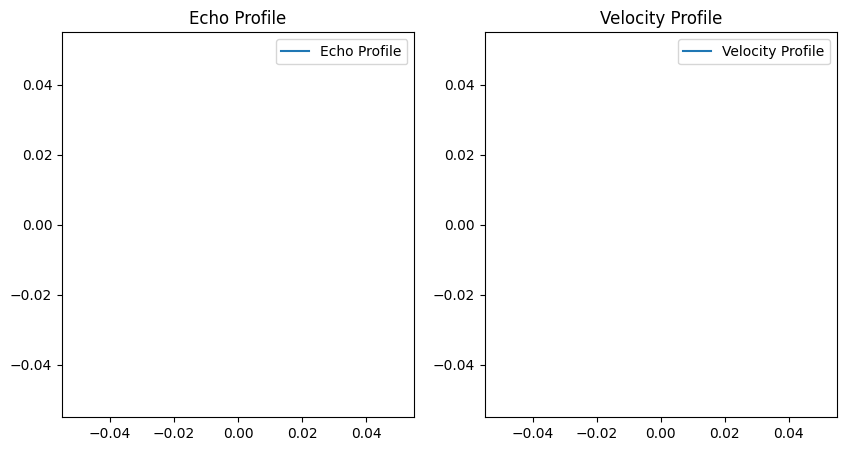

In [5]:
# Initialize the figure and axes
fig, (ax1, ax2) = subplots(1, 2, figsize=(10, 5))

#Initial plot setup
line1, = ax1.plot([], [], label="Echo Profile")
line2, = ax2.plot([], [], label="Velocity Profile")


"""Initialize the plots with empty data."""
ax1.set_title("Echo Profile")
# ax1.set_xlim(0, 100)  # Adjust limits as needed
#ax1.set_ylim(0, 1)    # Adjust limits as needed
ax1.legend()

ax2.set_title("Velocity Profile")
# ax2.set_xlim(0, 100)  # Adjust limits as needed
#ax2.set_ylim(-1, 1)   # Adjust limits as needed
ax2.legend()

line1.set_data([], [])
line2.set_data([], [])


myData=get_profile(myPeacock,use_config,10)
x = myData['x']
echo=myData['echo']
velocity=myData['velocity']

line1.set_data(x, echo[0])
line2.set_data(x, velocity[0])

show()



In [ ]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

nprofile = 0

# Initialize the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Initial plot setup
line1, = ax1.plot([], [], label="Echo Profile")
line2, = ax2.plot([], [], label="Velocity Profile")

def init():
    """Initialize the plots with empty data."""
    ax1.set_title("Echo Profile")
    # ax1.set_xlim(0, 100)  # Adjust limits as needed
    # ax1.set_ylim(0, 1)    # Adjust limits as needed
    ax1.legend()

    ax2.set_title("Velocity Profile")
    # ax2.set_xlim(0, 100)  # Adjust limits as needed
    # ax2.set_ylim(-1, 1)   # Adjust limits as needed
    ax2.legend()

    line1.set_data([], [])
    line2.set_data([], [])
    return line1, line2

def update(frame):
    """Update the plots with new data."""
    global nprofile
    nprofile += 1  # Increment profile index or update logic

    myData=get_profile(myPeacock,use_config,10)
    x = myData['x']
    echo=myData['echo']
    velocity=myData['velocity']

    line1.set_data(x, echo[0])
    line2.set_data(x, velocity[0])

    return line1, line2

# Create the animation
ani = FuncAnimation(fig, update, init_func=init, frames=100, interval=200, blit=True)

plt.show()

array([0.04401641, 1.3360981 , 4.07365199, 2.17147619, 2.24123553,
       1.86256103, 1.77599542, 1.54017418, 1.67595813, 2.5816291 ,
       1.96166464, 2.58896517, 2.57202552, 2.22536295, 2.18521465,
       2.29378846, 1.41546102, 2.35527805, 1.92431739, 1.98967508,
       3.19172321, 2.50800165, 2.22069454, 2.65085491, 4.08885766,
       1.9415238 , 1.09267402, 1.82548054, 1.83895223, 1.72130837,
       0.62343242, 1.96166464, 3.46275758, 2.39702694, 2.24910513])

# SAVING DATA
In the data file I store the whole data dict and boardSettings dict

In [51]:
fileName="./testFile.pkl"        
save_data(fileName,myData,boardSettings)        
#For very long acquisition, I will create a save function that stores the raw_data and the __config__ 
#and an extract_profile_fromFile function to reconstruct the profiles from the raw data

# READING DATA FROM FILE

In [52]:
#reading the data from a file:I am using the simplest pickle python native format.
data_file="./testFile.pkl"
Data,dataSettings=load_data(data_file)

soundspeed = 2500
f_emission = 2000000.0
tr_out = tr1
prf = 6993.006993006993
nb_cycles_per_emission = 14
overlap = 0.5
nb_emission_per_profile = 2
position_first_gate = 0.02
gate_distance = 0.0043749999999999995
nb_gates = 35
gate_size = 0.008749999999999999
method = ppc_cont
phase_coding = True
static_echo_filter = True
gain_function = {'auto': False, 'a0': 39.96329, 'a1': 0.0}
nb_profile_average = 1
v_min = -0.1000372939031671
dynamicRange = 4.37062937062937
v_max = 4.27062937062937


# BASIC FIGURES

## plotting Echo and Velocity as a function of $x$

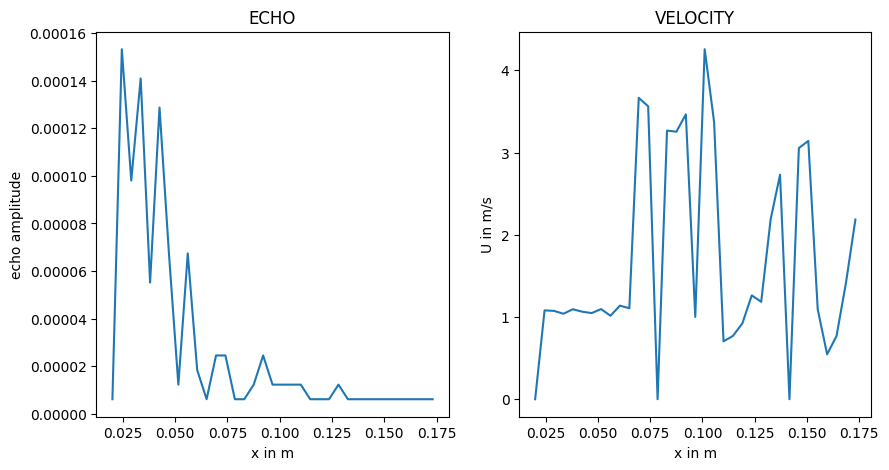

In [54]:
nprofile=0
  
fig,(ax1,ax2)=subplots(1,2,figsize=(10,5))
plot_echoProfile(myData,nprofile,ax1)
plot_velocityProfile(myData,nprofile,ax2)

## plotting Velocity as a function of $t$

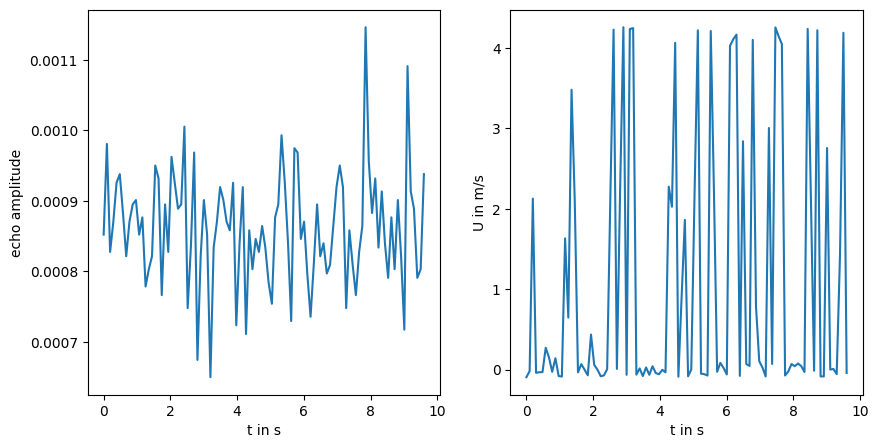

In [28]:
ngate=10 
fig,(ax1,ax2)=subplots(1,2,figsize=(10,5))
plot_echoTimeseries(myData,ngate,ax1)
plot_velocityTimeseries(myData,ngate,ax2)

# VARIOUS USEFUL FUNCTIONS:

* save settings to file
* load settings from board


## SAVE settings to file

In [ ]:
fileName='./CONFIG/myConfig.json'
save_settings_toFile(fileName,mySettings)       

## LOAD the settings from board

This is recommanded only if there is already a config loaded on the board.
If you have a ERROR sound speed is set to zero on the board, you must either:
* load a config from a file first or create one from scratch and then write it on the board
* overwrite the sound speed on the board before the load command(not recommanded)

In [ ]:
nconfig=0
boarSettings=load_settings_fromBoard(myPeacock,nconfig)

## HISTOGRAM sampling frequency

In [22]:
figure()
_=hist(myData['f_sampling'], bins=20)
ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# Example 1: of a standalone acquisition from a config file:

In [8]:
from API.apf04_driver import Apf04Driver
from API.low_level_functions_JN import *
from matplotlib.pyplot import *

config_fileName = './CONFIG/myConfig.json'
saveDataFile="./example1.pkl"  
use_config=0 #(where to write the config on the board, 0,1, or 2)
N_profiles=10

#initialize the board
myPeacock = Apf04Driver(230400, 18e6)
myPeacock.read_version()
#get the settings from file
mySettings=load_settings_fromFile(config_fileName)
#write the settings on the board
boardSettings=write_settings_toBoard(myPeacock,mySettings,use_config)
#start the acquisition
print('ACQUISITION START')
myData=get_profile(myPeacock,use_config,N_profiles)  
#save the data
save_data(saveDataFile,myData,boardSettings) 
print('FINISHED')

###########################################


Loaded settings


soundspeed :  1509
f_emission :  2571428.5714285714
tr_out :  tr1
prf :  1000.1666944490748
nb_cycles_per_emission :  128
overlap :  0.5
nb_emission_per_profile :  128
position_first_gate :  0.019952333333333336
gate_distance :  0.018778666666666666
nb_gates :  38
gate_size :  0.03755733333333333
method :  ppc_cont
phase_coding :  True
static_echo_filter :  True
gain_function :  {'auto': False, 'a0': 39.96329, 'a1': 0.0}
nb_profile_average :  1
v_min :  -0.06428613461466386
dynamicRange :  0.29346557759626607
v_max :  0.2291794429816022
###########################################
1509


Uploaded and checked configuration


soundspeed = 1509
f_emission = 2571428.5714285714
tr_out = tr1
prf = 1000.1666944490748
nb_cycles_per_emission = 128
overlap = 0.5
nb_emission_per_profile = 128
position_first_gate = 0.019952333333333336
gate_distance = 0.018778666666666666
nb_gates = 38
gate_size = 0.03755733333333333
method = ppc_cont


# Example 2: of a standalone acquisition using an existing config on the board:

In [ ]:
from API.apf04_driver import Apf04Driver
from API.low_level_functions_JN import *
from matplotlib.pyplot import *


saveDataFile="./example2.pkl"
use_config=0 #(which the config on the board, 0,1, or 2)
N_profiles=10

#initialize the board
myPeacock = Apf04Driver(230400, 18e6)
myPeacock.read_version()
#start the acquisition
print('ACQUISITION START')
myData=get_profile(myPeacock,use_config,N_profiles)  
#save the data
save_data(saveDataFile,myData,boardSettings) 
print('FINISHED')